In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('/Users/daviderickson/projects/datasf/data/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

In [4]:
df.shape

(2215024, 33)

In [5]:
print(df.columns)

Index(['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       ':@computed_region_yftq_j783', ':@computed_region_p5aj_wyqh',
       ':@computed_region_rxqg_mtj9', ':@computed_region_bh8s_q3mv',
       ':@computed_region_fyvs_ahh9', ':@computed_region_9dfj_4gjx',
       ':@computed_region_n4xg_c4py', ':@computed_region_4isq_27mq',
       ':@computed_region_fcz8_est8', ':@computed_region_pigm_ib2e',
       ':@computed_region_9jxd_iqea', ':@computed_region_6pnf_4xz7',
       ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi',
       ':@computed_region_nqbw_i6c3', ':@computed_region_2dwj_jsy4'],
      dtype='object')


In [6]:
df.head(5)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,...,:@computed_region_n4xg_c4py,:@computed_region_4isq_27mq,:@computed_region_fcz8_est8,:@computed_region_pigm_ib2e,:@computed_region_9jxd_iqea,:@computed_region_6pnf_4xz7,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_2dwj_jsy4
0,180362289,VEHICLE THEFT,STOLEN MOTORCYCLE,Tuesday,05/15/2018,10:30,SOUTHERN,NONE,700 Block of TEHAMA ST,-122.411912,...,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN
1,180360948,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Tuesday,05/15/2018,04:14,SOUTHERN,NONE,MARKET ST / SOUTH VAN NESS AV,-122.419258,...,1.0,NaN,1.0,NaN,8.0,2.0,1.0,1.0,1.0,NaN
2,180360879,OTHER OFFENSES,PAROLE VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,...,NaN,15.0,3.0,15.0,NaN,2.0,NaN,NaN,3.0,NaN
3,180360879,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,...,NaN,15.0,3.0,15.0,NaN,2.0,NaN,NaN,3.0,NaN
4,180360879,OTHER OFFENSES,TRAFFIC VIOLATION,Tuesday,05/15/2018,02:01,MISSION,"ARREST, BOOKED",CAPP ST / 21ST ST,-122.417813,...,NaN,15.0,3.0,15.0,NaN,2.0,NaN,NaN,3.0,NaN


In [7]:
df[['Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods']].head(5)

,Address,X,Y,Location,PdId,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,700 Block of TEHAMA ST,-122.411912,37.775207,"(37.77520656149669, -122.41191202732877)",18036228907023,32.0,1.0,10.0,34.0
1,MARKET ST / SOUTH VAN NESS AV,-122.419258,37.775146,"(37.77514629165388, -122.41925789481357)",18036094864020,32.0,1.0,10.0,20.0
2,CAPP ST / 21ST ST,-122.417813,37.757101,"(37.757100579642824, -122.41781255878655)",18036087926150,53.0,3.0,2.0,20.0
3,CAPP ST / 21ST ST,-122.417813,37.757101,"(37.757100579642824, -122.41781255878655)",18036087965010,53.0,3.0,2.0,20.0
4,CAPP ST / 21ST ST,-122.417813,37.757101,"(37.757100579642824, -122.41781255878655)",18036087965015,53.0,3.0,2.0,20.0


In [8]:
df.describe()

,IncidntNum,X,Y,PdId,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,:@computed_region_yftq_j783,:@computed_region_p5aj_wyqh,...,:@computed_region_n4xg_c4py,:@computed_region_4isq_27mq,:@computed_region_fcz8_est8,:@computed_region_pigm_ib2e,:@computed_region_9jxd_iqea,:@computed_region_6pnf_4xz7,:@computed_region_6ezc_tdp2,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_2dwj_jsy4
count,2.215024e+06,2.215024e+06,2.215024e+06,2.215024e+06,2.208947e+06,2.213912e+06,2.214363e+06,2.213967e+06,2.209444e+06,2.213501e+06,...,320205.0,564496.000000,473794.000000,570165.000000,565021.000000,2.213967e+06,340938.0,341126.0,503448.000000,119091.000000
mean,1.040728e+08,-1.224229e+02,3.777076e+01,1.040728e+13,5.220508e+01,4.874528e+00,6.832845e+00,2.187302e+01,8.605482e+00,5.086868e+00,...,1.0,14.106791,2.155272,13.912473,6.297216,1.597475e+00,1.0,1.0,2.322856,36.712774
std,4.612827e+07,2.983459e-02,4.203596e-01,4.612827e+12,3.158740e+01,2.782250e+00,3.394744e+00,1.272125e+01,4.276287e+00,2.990329e+00,...,0.0,6.116613,1.182136,6.299596,2.516868,4.904066e-01,0.0,0.0,1.328072,10.222076
min,3.979000e+03,-1.225136e+02,3.770788e+01,3.979630e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.000000,2.000000
25%,6.124170e+07,-1.224332e+02,3.775302e+01,6.124170e+12,2.500000e+01,3.000000e+00,3.000000e+00,9.000000e+00,5.000000e+00,2.000000e+00,...,1.0,10.000000,1.000000,9.000000,5.000000,1.000000e+00,1.0,1.0,1.000000,35.000000
50%,1.011558e+08,-1.224166e+02,3.777542e+01,1.011558e+13,4.400000e+01,5.000000e+00,8.000000e+00,2.100000e+01,9.000000e+00,4.000000e+00,...,1.0,15.000000,3.000000,15.000000,6.000000,2.000000e+00,1.0,1.0,3.000000,35.000000
75%,1.409256e+08,-1.224069e+02,3.778448e+01,1.409256e+13,8.400000e+01,7.000000e+00,1.000000e+01,3.400000e+01,1.300000e+01,8.000000e+00,...,1.0,18.000000,3.000000,18.000000,7.000000,2.000000e+00,1.0,1.0,3.000000,35.000000
max,9.915824e+08,-1.205000e+02,9.000000e+01,9.915824e+13,1.170000e+02,1.000000e+01,1.100000e+01,4.100000e+01,1.500000e+01,1.000000e+01,...,1.0,25.000000,5.000000,25.000000,15.000000,2.000000e+00,1.0,1.0,5.000000,80.000000


In [9]:
corr = df.corr()

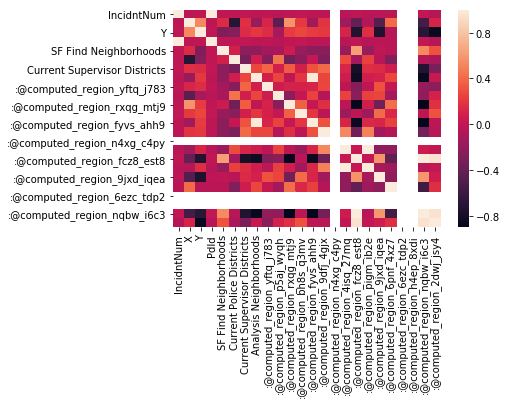

In [10]:
sns.heatmap(corr)

In [12]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
print(pca)

print(df.shape)
    
dummies_cols = ['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution']
drop_cols = ['Date', 'Time', 'Address', 'Location'] #Date and Tme can be handled better
df1 = pd.get_dummies(df, columns=dummies_cols)
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.dropna(axis=0)
X = df1.loc[:,:].values
X_cols = df1.loc[:,:].columns

scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

pca.fit(X_transformed)
X_pca = pca.fit(X_transformed).transform(X_transformed)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(2215024, 33)


Text(0, 0.5, 'Explained Variance')

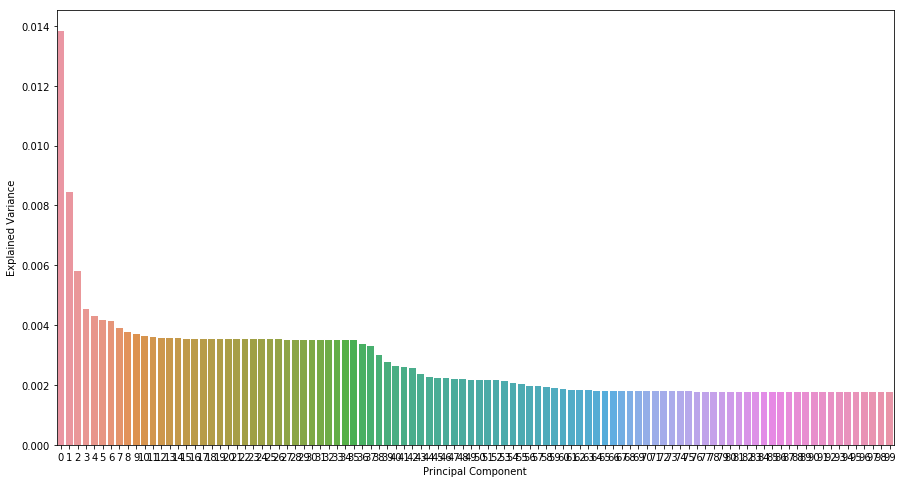

In [25]:
# Explained Variance 
plt.figure(figsize=(15,8))
ax = sns.barplot(x=np.arange(100), y=pca.explained_variance_[0:100]/sum(pca.explained_variance_))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')

519.0 PCA components explain all variance.
1012.0 total features
0.5128458498023716 % of all features


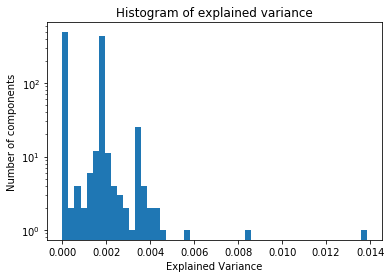

In [27]:
# Histogram of explained variance
vals, bins, patches = plt.hist(pca.explained_variance_/sum(pca.explained_variance_), log=True, bins=50)
plt.title('Histogram of explained variance')
plt.xlabel('Explained Variance')
plt.ylabel('Number of components')

# Observations
num_exp_var = np.sum(vals)-vals[0] #
print(num_exp_var, 'PCA components explain all variance.')
print(np.sum(vals), 'total features')
print(num_exp_var/np.sum(vals), '% of all features')

In [15]:
cols_list = ['Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods']
for col in cols_list:
    series = df[col]
    series.unique()
    print(col, '- unique entries - ', len(series.unique()))

Address - unique entries -  25147
X - unique entries -  60620
Y - unique entries -  58674
Location - unique entries -  61430
PdId - unique entries -  2215024
SF Find Neighborhoods - unique entries -  118
Current Police Districts - unique entries -  11
Current Supervisor Districts - unique entries -  12
Analysis Neighborhoods - unique entries -  42


In [16]:
df.count()

IncidntNum                      2215024
Category                        2215024
Descript                        2215024
DayOfWeek                       2215024
Date                            2215024
Time                            2215024
PdDistrict                      2215023
Resolution                      2215024
Address                         2215024
X                               2215024
Y                               2215024
Location                        2215024
PdId                            2215024
SF Find Neighborhoods           2208947
Current Police Districts        2213912
Current Supervisor Districts    2214363
Analysis Neighborhoods          2213967
:@computed_region_yftq_j783     2209444
:@computed_region_p5aj_wyqh     2213501
:@computed_region_rxqg_mtj9     2214363
:@computed_region_bh8s_q3mv     2214529
:@computed_region_fyvs_ahh9     2213967
:@computed_region_9dfj_4gjx      548407
:@computed_region_n4xg_c4py      320205
:@computed_region_4isq_27mq      564496
